In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Brain Tumor MRI Dataset

/content/drive/MyDrive/Brain Tumor MRI Dataset


In [ ]:
pip install colorama

In [ ]:
import os
import random
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print('Training:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')

print(Fore.WHITE + 'Testing:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')

Training:

glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457

Testing:

glioma: 300
meningioma: 306
notumor: 405
pituitary: 300



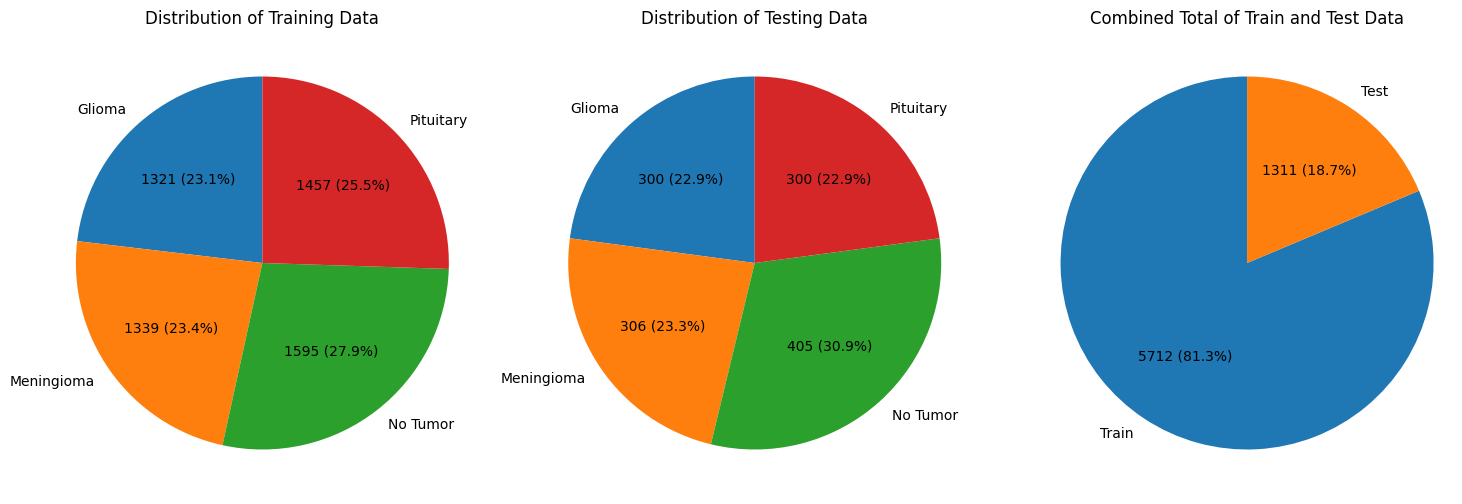

In [ ]:
# Data for training and testing
train_counts = [1321, 1339, 1595, 1457]
test_counts = [300, 306, 405, 300]
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

total_train = sum(train_counts)
total_test = sum(test_counts)
total_labels = ['Train', 'Test']
total_counts = [total_train, total_test]

# Custom function for autopct to ensure accurate numbers
def custom_autopct(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute} ({pct:.1f}%)"

def plot_pie_chart(data, labels, title, ax):
    ax.pie(data, labels=labels, autopct=lambda pct: custom_autopct(pct, data), startangle=90)
    ax.axis('equal')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_pie_chart(train_counts, labels, "Distribution of Training Data", axs[0])
plot_pie_chart(test_counts, labels, "Distribution of Testing Data", axs[1])
plot_pie_chart(total_counts, total_labels, "Combined Total of Train and Test Data", axs[2])

plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='training',
                                             label_mode = 'categorical',
                                             seed=42)

validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='validation',
                                             label_mode = 'categorical',
                                             seed=42)

test_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode = 'categorical',
                                            )
# prefetch the train_dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
# this cell to enable me to evaluate the model in confusion matrix
y_true = np.concatenate([ y for _ , y in test_dataset] , axis = 0)

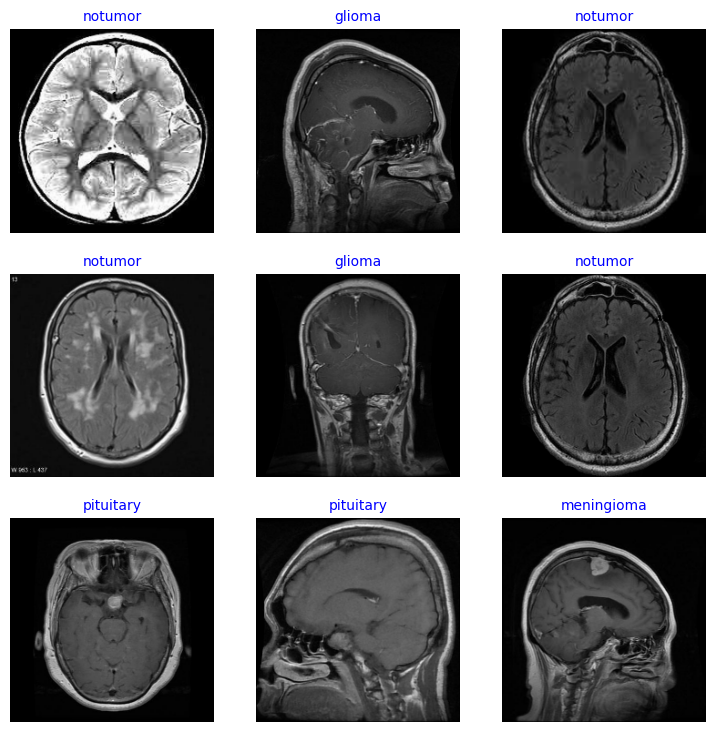

In [ ]:
class_names = test_dataset.class_names
plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")

In [ ]:
# Hyperparameters
from tensorflow.keras.optimizers import legacy

IMG_SHAPE = IMG_SIZE + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42

In [ ]:
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

In [ ]:
# function for plot resultes

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

# for make dataframe for all model
model_name= ['My_model','DenseNet121','VGG16','ResNet50V2','MobileNetV2','EfficientNetV2S','Xception']
CategoricalAccuracy= []
losses= []

In [ ]:
model = Sequential([
    tfl.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(64, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(128, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(256, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Flatten(),
    tfl.Dense(512, activation='relu'),
    tfl.Dropout(0.5),
    tfl.Dense(4, activation='softmax')
])

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('my_model')
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 5.6747 - categorical_accuracy: 0.7012
Epoch 1: val_loss improved from inf to 0.48445, saving model to model.my_model.h5
152/152 [==============================] - 840s 6s/step - loss: 5.6747 - categorical_accuracy: 0.7012 - val_loss: 0.4845 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.4268 - categorical_accuracy: 0.8548
Epoch 2: val_loss improved from 0.48445 to 0.36874, saving model to model.my_model.h5
152/152 [==============================] - 724s 5s/step - loss: 0.4268 - categorical_accuracy: 0.8548 - val_loss: 0.3687 - val_categorical_accuracy: 0.8785 - lr: 0.0010
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.3121 - categorical_accuracy: 0.8927
Epoch 3: val_loss improved from 0.36874 to 0.36199, saving model to model.my_model.h5
152/152 [==============================] - 735s 5s/step - loss: 0.3121 - categorical

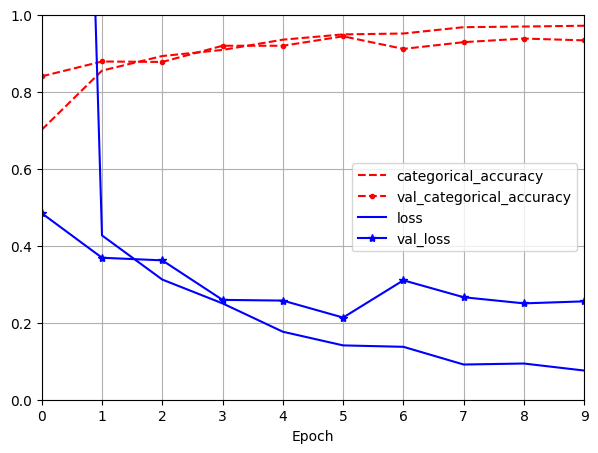

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 59s 1s/step - loss: 0.2169 - categorical_accuracy: 0.9481


In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 56s 1s/step - loss: 0.2169 - categorical_accuracy: 0.9481


In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.densenet import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_densenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_densenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_densenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)

from tensorflow.keras.applications import DenseNet121

dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
dense_model.trainable = False

x = dense_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=dense_model.input, outputs=predictions)

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy() , keras.metrics.Recall()])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
callbacks = get_callbacks('DenseNet121')

history = model.fit(
    train_dataset_densenet,
    epochs=10,
    validation_data=validation_dataset_densenet,
    callbacks=callbacks
)

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.5262 - categorical_accuracy: 0.8110 - recall: 0.7897
Epoch 1: val_loss improved from inf to 0.30213, saving model to model.DenseNet121.h5
152/152 [==============================] - 1042s 7s/step - loss: 0.5262 - categorical_accuracy: 0.8110 - recall: 0.7897 - val_loss: 0.3021 - val_categorical_accuracy: 0.8808 - val_recall: 0.8586 - lr: 0.0010
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2445 - categorical_accuracy: 0.9084 - recall: 0.8989
Epoch 2: val_loss improved from 0.30213 to 0.22531, saving model to model.DenseNet121.h5
152/152 [==============================] - 1101s 7s/step - loss: 0.2445 - categorical_accuracy: 0.9084 - recall: 0.8989 - val_loss: 0.2253 - val_categorical_accuracy: 0.9112 - val_recall: 0.9030 - lr: 0.0010
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.1911 - categorical_accuracy: 0.9281 - recall: 0.9222
Epoch 3: val_loss improved from 0.2

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4424 - categorical_accuracy: 0.8383
Epoch 1: val_loss improved from inf to 0.26698, saving model to model.ResNet50V2.h5
152/152 [==============================] - 1194s 8s/step - loss: 0.4424 - categorical_accuracy: 0.8383 - val_loss: 0.2670 - val_categorical_accuracy: 0.9042 - lr: 0.0010
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.1970 - categorical_accuracy: 0.9277
Epoch 2: val_loss improved from 0.26698 to 0.21477, saving model to model.ResNet50V2.h5
152/152 [==============================] - 931s 6s/step - loss: 0.1970 - categorical_accuracy: 0.9277 - val_loss: 0.2148 - val_categorical_accuracy: 0.9194 - lr: 0.0010
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.1351 - categorical_accuracy: 0.9535
Epoch 3: val_loss did not improve from 0.21477
152/152 [==============================] - 922s 6s/st

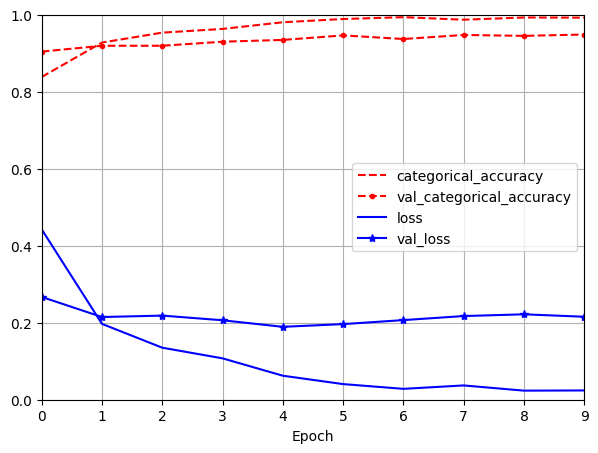

41/41 [==============================] - 210s 5s/step - loss: 0.2088 - categorical_accuracy: 0.9519


In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.densenet import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_resnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_resnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_resnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import ResNet50V2
ResNet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
ResNet_model.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=ResNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('ResNet50V2')
history = model.fit(
    train_dataset_resnet,
    epochs=10,
    validation_data=validation_dataset_resnet,
    callbacks=callbacks
)

plot()
loss, categorical_accuracy = model.evaluate(test_dataset_densenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)